In [24]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely

In [3]:
all_csvs = glob.glob('./out/sentinel*aea_merged.csv')
all_csvs.sort()

In [4]:
def read_process_csv(csv):
    temp_df = pd.read_csv(csv)
    temp_df['satellite'] = os.path.basename(csv)[:8]
    temp_df['year'] = int(os.path.basename(csv)[9:13])
    return temp_df

In [5]:

full_df = pd.concat([
    read_process_csv(csv) for csv in all_csvs
])

full_df = full_df.loc[full_df['hydropoly_max']<100]
full_df['area_ha'] = full_df['area']*100/10000 # HA
full_df['area_km'] = full_df['area']*100/(1000*1000) # km2
full_df = full_df.loc[full_df['area_ha']<100] # Remove less than 100 ha

In [7]:
full_df.shape

(2350378, 19)

In [8]:

groupby_year_sat = full_df.groupby(['year', 'satellite']).agg(
    {'area_ha': ['mean','median','sum','count']}
)

In [9]:
print(groupby_year_sat)

                 area_ha                           
                    mean median        sum    count
year satellite                                     
2017 sentinel   0.587201   0.18  670833.03  1142425
2023 sentinel   0.601930   0.18  727103.41  1207953


# Basic area distribution stats

In [23]:
print(full_df.loc[full_df.year==2023, 'area_km'].sum())
print(full_df.loc[(full_df.year==2023) & (full_df.area_ha > 5), 'area_km'].sum())

7271.034100000001
2676.8031


(array([3.39418e+05, 2.89616e+05, 1.91165e+05, 8.41330e+04, 5.66080e+04,
        4.11220e+04, 2.70000e+04, 1.85890e+04, 1.70130e+04, 1.39670e+04,
        1.14670e+04, 1.06820e+04, 7.58100e+03, 7.96600e+03, 5.70400e+03,
        5.65000e+03, 5.67800e+03, 4.02100e+03, 4.44000e+03, 3.26700e+03,
        3.31500e+03, 3.00000e+03, 3.09700e+03, 2.42400e+03, 2.14300e+03,
        2.10700e+03, 2.01100e+03, 2.10200e+03, 1.68900e+03, 1.44000e+03,
        1.43400e+03, 1.42700e+03, 1.53500e+03, 1.17900e+03, 1.05500e+03,
        1.09400e+03, 1.07700e+03, 1.10900e+03, 9.59000e+02, 7.87000e+02,
        8.79000e+02, 7.21000e+02, 8.02000e+02, 7.19000e+02, 6.86000e+02,
        7.16000e+02, 5.32000e+02, 6.35000e+02, 5.16000e+02, 5.49000e+02,
        5.72000e+02, 4.48000e+02, 5.56000e+02, 3.89000e+02, 4.58000e+02,
        4.79000e+02, 3.57000e+02, 4.34000e+02, 3.32000e+02, 3.88000e+02,
        3.63000e+02, 2.98000e+02, 3.47000e+02, 2.80000e+02, 3.12000e+02,
        3.30000e+02, 2.62000e+02, 3.11000e+02, 2.24

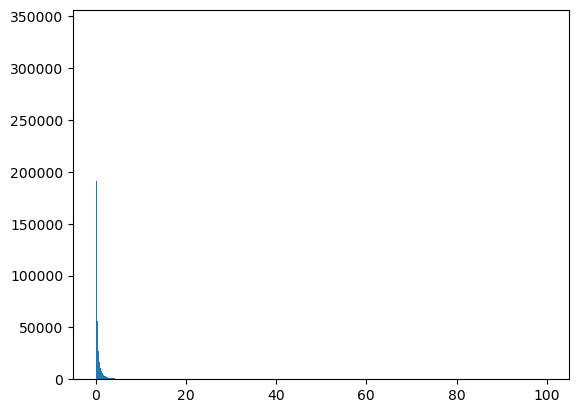

In [12]:
plt.hist(full_df.loc[full_df['year'] == 2023, 'area_ha'], bins=np.arange(0, 100, 0.1))

# Map

In [35]:
# Temporary: Convert to lat/lon
for csv in all_csvs:
    print(csv, ', Starting')
    out_path = csv.replace('aea', 'wgs84')
    if not os.path.isfile(out_path):
        temp_df = pd.read_csv(csv)
        temp_df = temp_df[['center_lat', 'center_lon', 'hydropoly_max', 'area']]
        gdf = gpd.GeoDataFrame(
            temp_df, geometry=gpd.points_from_xy(temp_df.center_lon, temp_df.center_lat),
            crs='ESRI:102033'
        )
        gdf_wgs84 = gdf.to_crs('EPSG:4326')
        gdf_wgs84['longitude'] = gdf_wgs84.geometry.x
        gdf_wgs84['latitude'] = gdf_wgs84.geometry.y
        gdf_wgs84.drop(columns=['geometry']).to_csv(out_path, index=False)
    print(out_path, ', Done')

./out/sentinel_2017_v5_aea_merged.csv , Starting
./out/sentinel_2017_v5_wgs84_merged.csv , Done
./out/sentinel_2023_v5_aea_merged.csv , Starting
./out/sentinel_2023_v5_wgs84_merged.csv , Done


In [36]:

all_csvs = glob.glob('./out/sentinel*wgs84_merged.csv')
all_csvs.sort()

full_wgs84_df = pd.concat([
    read_process_csv(csv) for csv in all_csvs
])

full_wgs84_df = full_wgs84_df.loc[full_wgs84_df['hydropoly_max']<100]
full_wgs84_df['area_ha'] = full_wgs84_df['area']*100/10000 # HA
full_wgs84_df['area_km'] = full_wgs84_df['area']*100/(1000*1000) # km2
full_wgs84_df = full_wgs84_df.loc[full_wgs84_df['area_ha']<100] # Remove less than 100 ha

In [43]:
full_wgs84_df.loc[full_wgs84_df.year==2023]['area_km'].sum()

7271.034100000001

In [37]:
brazil_gdf = gpd.read_file('/home/ksolvik/research/reservoirs/analysis/data/misc/general_borders/Brazilian_States_aea.shp')
brazil_gdf = gpd.read_file('/home/ksolvik/research/reservoirs/analysis/data/misc/general_borders/Brazilian_States_aea.shp')
brazil_gdf = brazil_gdf.to_crs('EPSG:4326')
brazil_gdf = brazil_gdf.dissolve(by='REGIAO')

In [38]:

xlims = brazil_gdf.bounds.min()['minx'], brazil_gdf.bounds.max()['maxx']
xlims = (xlims[0] - 1.5, xlims[1]-4)
ylims = brazil_gdf.bounds.min()['miny'], brazil_gdf.bounds.max()['maxy']
ylims = (ylims[0] - 1, ylims[1] + 1)
ylims_range = ylims[1] - ylims[0]
xlims_range = xlims[1] - xlims[0]

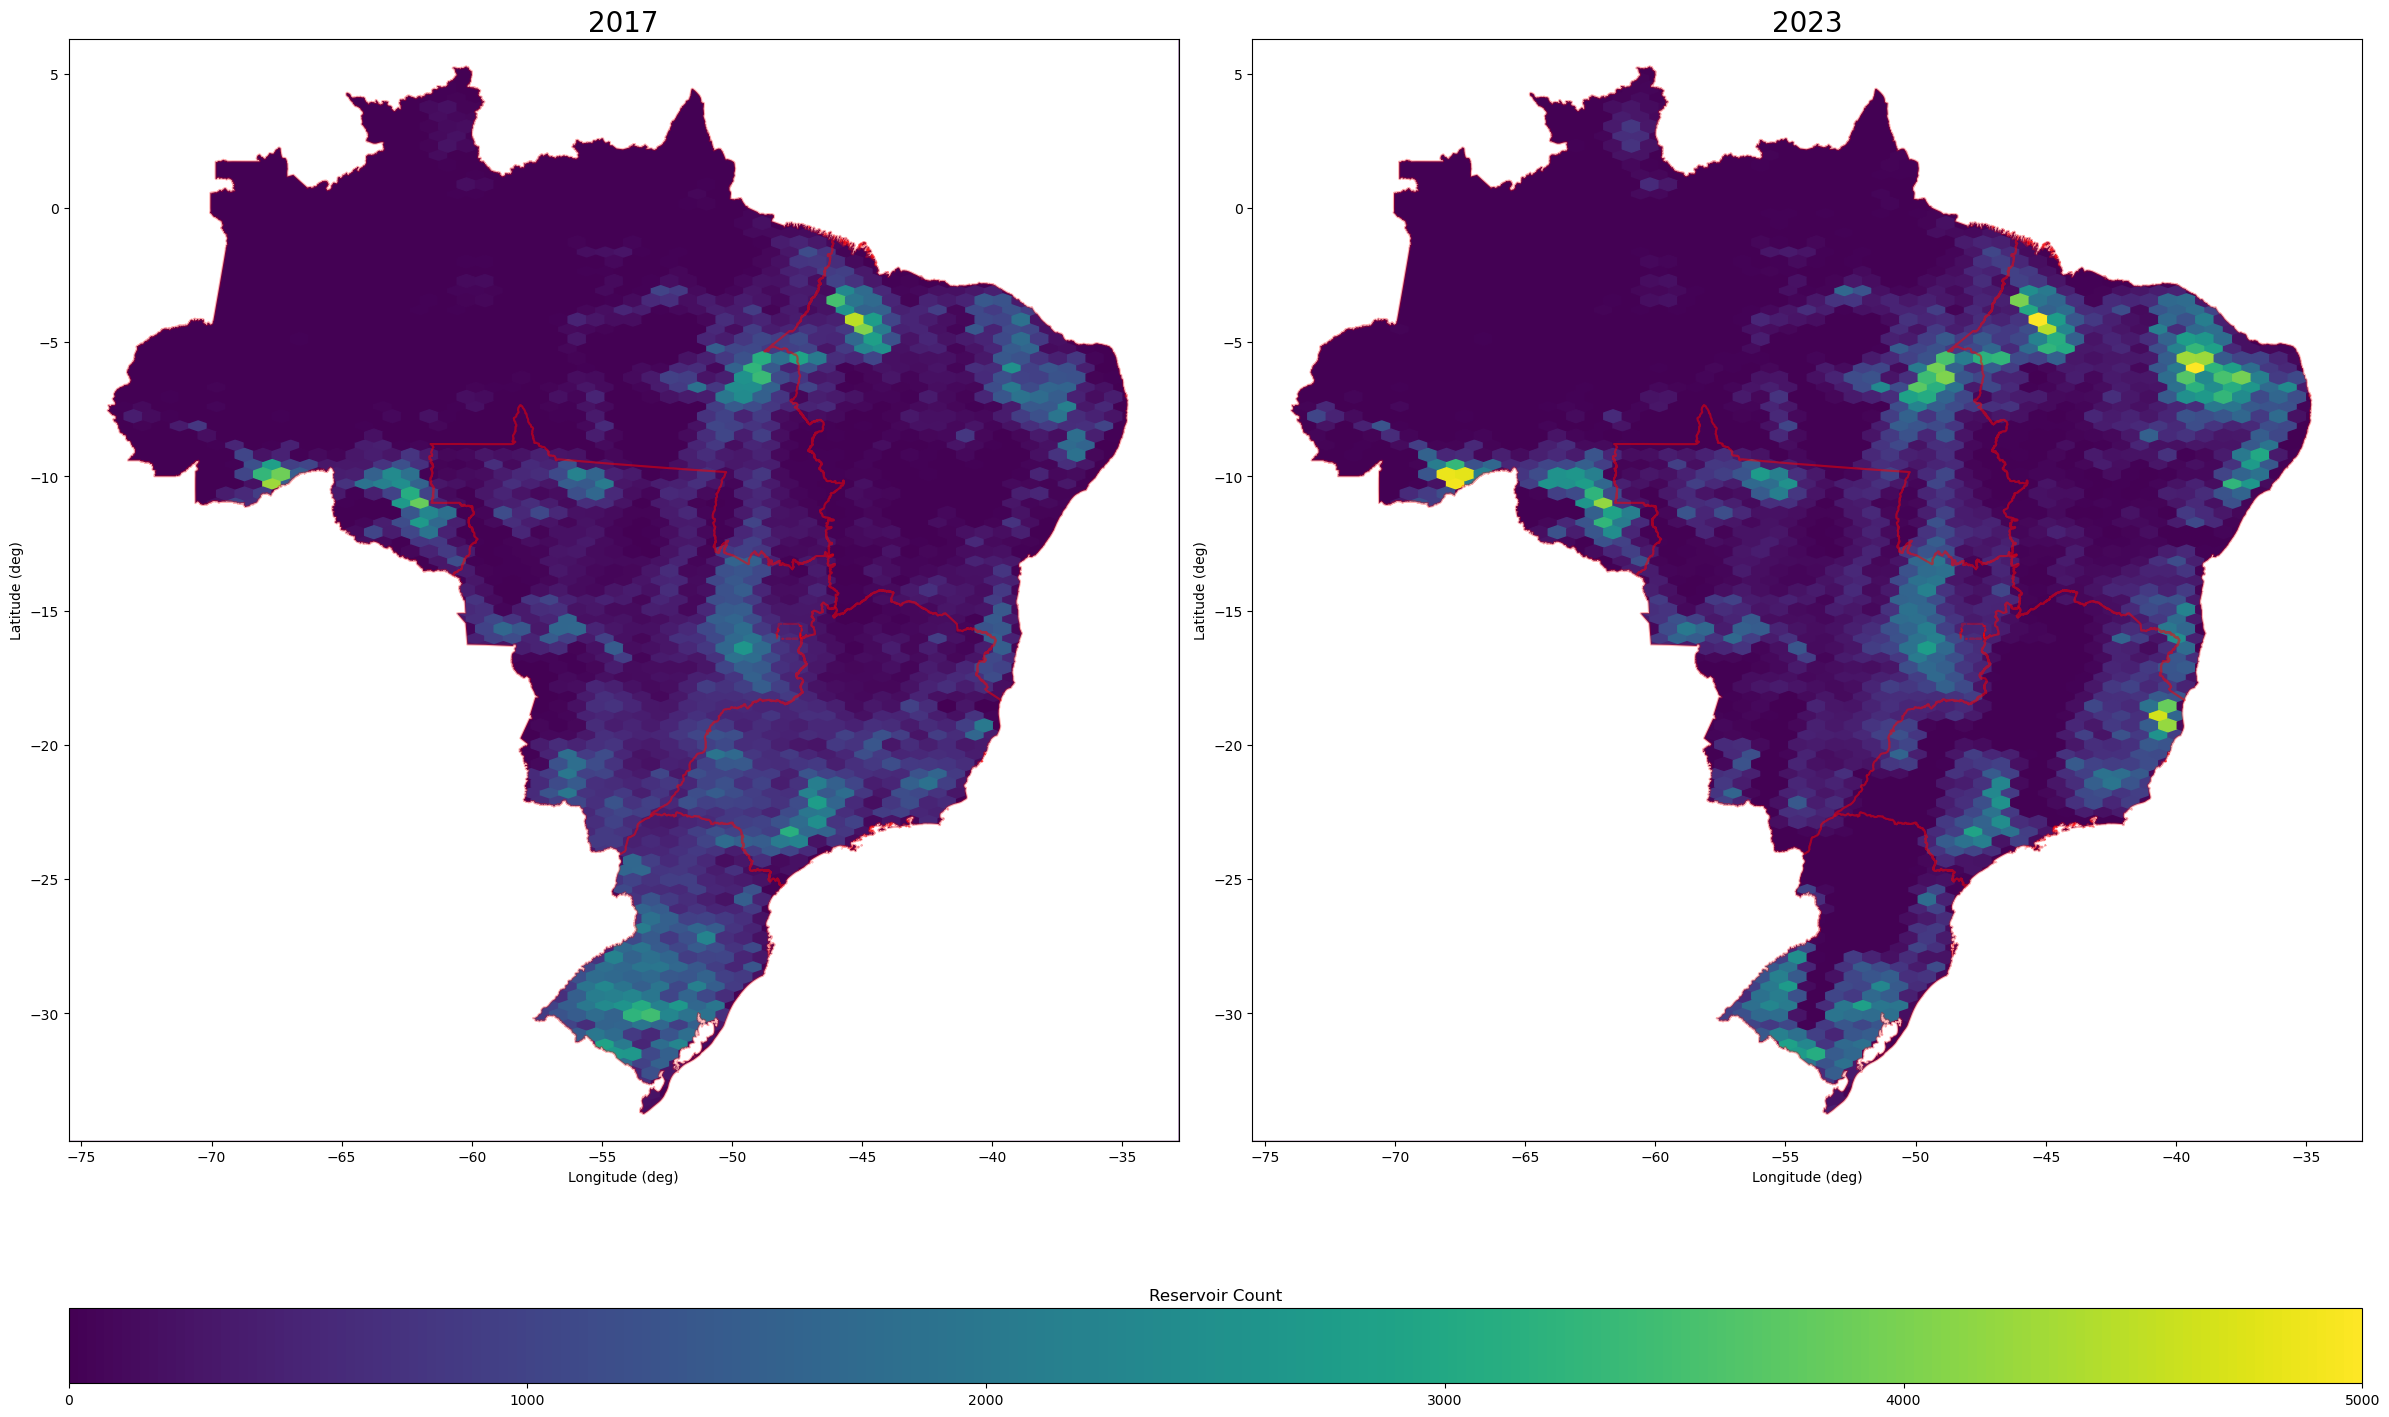

In [44]:

%matplotlib inline

axes_height_ratios=[1, 0.05]
fig, axs = plt.subplots(2, 2, figsize = (24, 16),
                       gridspec_kw={"height_ratios":axes_height_ratios})

# Plot 2017 first
brazil_gdf.boundary.plot(ax=axs[0, 0], color='red', alpha=0.3)


outline_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries(shapely.geometry.Polygon(
        [[xlims[0], ylims[0]],
         [xlims[0], ylims[1]],
         [xlims[1], ylims[1]],
         [xlims[1], ylims[0]],
         [xlims[0], ylims[0]]])),
    crs='EPSG:4326')
nonbrazil_poly = outline_gdf.overlay(brazil_gdf, how='difference')


year_2017_df = full_wgs84_df.loc[full_wgs84_df['year']==2017]
axs[0,0].hexbin(year_2017_df['longitude'], year_2017_df['latitude'],
              gridsize=(60, int(60*ylims_range/xlims_range)),
             vmin=0, vmax=5000,
             extent=xlims + ylims)

# Plot 2023
brazil_gdf.boundary.plot(ax=axs[0, 1], color='red', alpha=0.3)
year_2023_df = full_wgs84_df.loc[full_wgs84_df['year']==2023]
im = axs[0, 1].hexbin(year_2023_df['longitude'], year_2023_df['latitude'],
              gridsize=(60, int(60*ylims_range/xlims_range)),
             vmin=0, vmax=5000,
             extent=xlims + ylims)

# fig.colorbar(im)

for cur_ax in axs[0]:
    cur_ax.set_xlabel('Longitude (deg)')
    cur_ax.set_ylabel('Latitude (deg)')
    cur_ax.set_xlim(xlims)
    cur_ax.set_ylim(ylims)
axs[0,0].set_title('2017', size=20)
axs[0,1].set_title('2023', size=20)

# Remove outside of Brazil
nonbrazil_poly.plot(ax=axs[0,1],color='white')
nonbrazil_poly.plot(ax=axs[0,0],color='white')

# Set up colorbar
gs = axs[0, 0].get_gridspec()
for ax in axs[-1]:
    ax.remove()
axbig = fig.add_subplot(gs[-1, :])
axbig.set_title('Reservoir Count')
fig.colorbar(im, cax=axbig, orientation='horizontal')
fig.tight_layout()